# Top 20 ASV by Percencent Reads

## 18S

### Import Modules

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from palettable.tableau import Tableau_20 as pr
from sklearn.linear_model import LinearRegression

### Load data files
Create a proper path to your ASV, metadata, and taxa files. Check the format to see that they are the right format with the correct ASV and sample name labels. Make sure for the taxa and ASV tables that the ASV# is indexed. In addition, for the metadata make sure the sample names are indexed and that it matches with the sample name columns in the ASV table.

In [64]:
filename_asv18s = 'outside_influence/data/filtered_seq_data/outside_18S_asv_filtered.csv'
filename_meta18s = 'outside_influence/data/filtered_seq_data/outside_18S_meta_filtered.csv'
filename_taxa18s = 'outside_influence/data/filtered_seq_data/outside_18S_taxa_filtered.csv'

df_asv18 = pd.read_csv(filename_asv18s, na_values=-999, index_col=0)
df_meta18 = pd.read_csv(filename_meta18s, na_values=-999, index_col=0)
df_taxa18 = pd.read_csv(filename_taxa18s, na_values=-999, index_col=0)

In [65]:
df_metasub18 = df_meta18[df_meta18['SAMPLING_station'].isin(['C1', 'c1'])]
#df_metasub18 = df_meta18[df_meta18['SAMPLING_station'].isin(['MOORING1', 'mooring1', 'Mooring 1', 'M1', 'moring1', 'Mooring1'])] #Subsample M1
#df_metasub18 = df_meta18[df_meta18['SAMPLING_station'].isin(['MOORING2', 'mooring2', 'Mooring 2'])]#Subsample M2

In [66]:
cmap=pr.mpl_colormap
#levels= ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
levels= ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
df_asv18 = df_asv18.div(df_asv18.sum(axis=0), axis=1) *100
df18= pd.concat([df_metasub18['date'], df_asv18.T], axis=1,join='inner')
df18.index.name = 'sample_name'
df18['Date'] = pd.to_datetime(df18['date'], errors='coerce')
df18['Date'] = pd.to_datetime(df18['Date'], format='%Y-%m-%d %H:%M:%S')
df18['YearMonth'] = df18['Date'].dt.to_period('M')
#df18['year'] = df18['Date'].dt.year
df18 = df18.drop(['date','Date'], axis =1)
df18 = df18.groupby('YearMonth').mean(numeric_only=True)
full_index = pd.period_range(start='2008-01', end='2023-01', freq='M')
df18 = df18.reindex(full_index)
df18=df18.T
df18['Tot'] = df18.sum(axis=1)
df18=df18.loc[df18['Tot']>0]
col_name18 = list(df18)[-1]
df18.drop(col_name18, axis=1, inplace=True)
df18=pd.concat([df18, df_taxa18], axis=1, join='inner')
df_line = df18[df18['Class'] == 'Dinophyceae'] #Pick a taxa for the first subset
df_line2 = df18[df18['Phylum'] == 'Bacillariophyta'] #Pick a taxa for the first subset
df_line = df_line.drop(['Kingdom'] , axis = 1)
df_line2 = df_line2.drop(['Kingdom'] , axis = 1)
df_line=df_line.groupby(levels).sum()
df_line2=df_line2.groupby(levels).sum()
df_line=df_line.T
df_line['sum'] = df_line.sum(axis=1)
df_line2=df_line2.T
df_line2['sum2'] = df_line2.sum(axis=1)
df_sum = df_line['sum']
df_sum2 = df_line2['sum2']
df_two = pd.concat([df_sum, df_sum2], axis=1)

In [67]:
df18 = df18[df18['Class'] == 'Dinophyceae'] #Change depending on which taxa top 20 you want to see.
df18 = df18.drop(['Kingdom'] , axis = 1)
df18=df18.groupby(levels).sum()
df18['Tot'] = df18.sum(axis=1)
df18=df18.sort_values('Tot', ascending=False)

df18=df18.head(n=20)
col_name18 = list(df18)[-1]
df18.drop(col_name18, axis=1, inplace=True)
df18 = df18.sort_index()
df18=df18.T
df18 = df18.sort_index()
df_joined = pd.concat([df18, df_two], axis=1)

### Graph the group percent read change and add a trendline

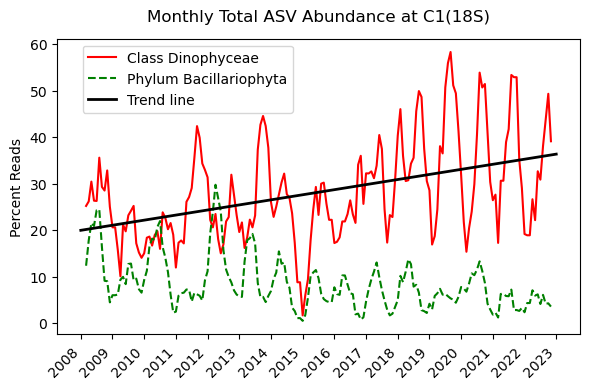

In [37]:
y = df_joined['sum']
y2 = df_joined['sum2']

y = y.rolling(window=5, center=True).mean()
y2 = y2.rolling(window=5, center=True).mean()

x_vals = np.arange(len(df_joined)).reshape(-1, 1)
y_vals = df_joined['sum'].values.reshape(-1, 1)
Fit linear regression model
model = LinearRegression()
model.fit(x_vals, y_vals)
trend_line = model.predict(x_vals)
plt.figure(figsize=(6, 4))
plt.plot(df_joined.index.astype(str), y, '-', color='red', label='Class Dinophyceae', linewidth=1.5)
plt.plot(df_joined.index.astype(str), y2, '--', color='green', label='Phylum Bacillariophyta', linewidth=1.5)
plt.plot(df_joined.index.astype(str), trend_line, color='black', linestyle='-', linewidth=2, label='Trend line')
plt.title('Monthly Total ASV Abundance at C1(18S)', y=1.03, fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.25, 1.0), ncol=1, fontsize=10)
idx_str = df_joined.index.astype(str)
positions = [i for i, x in enumerate(idx_str) if x.endswith('-01')]
labels = [x[:4] for x in idx_str if x.endswith('-01')]
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(labels, rotation=45, ha='right')

plt.ylabel('Percent Reads')
plt.tight_layout()
#plt.savefig("Seasonal_images/Monthly_ASV_C_Dinophyceae.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 600x400 with 0 Axes>

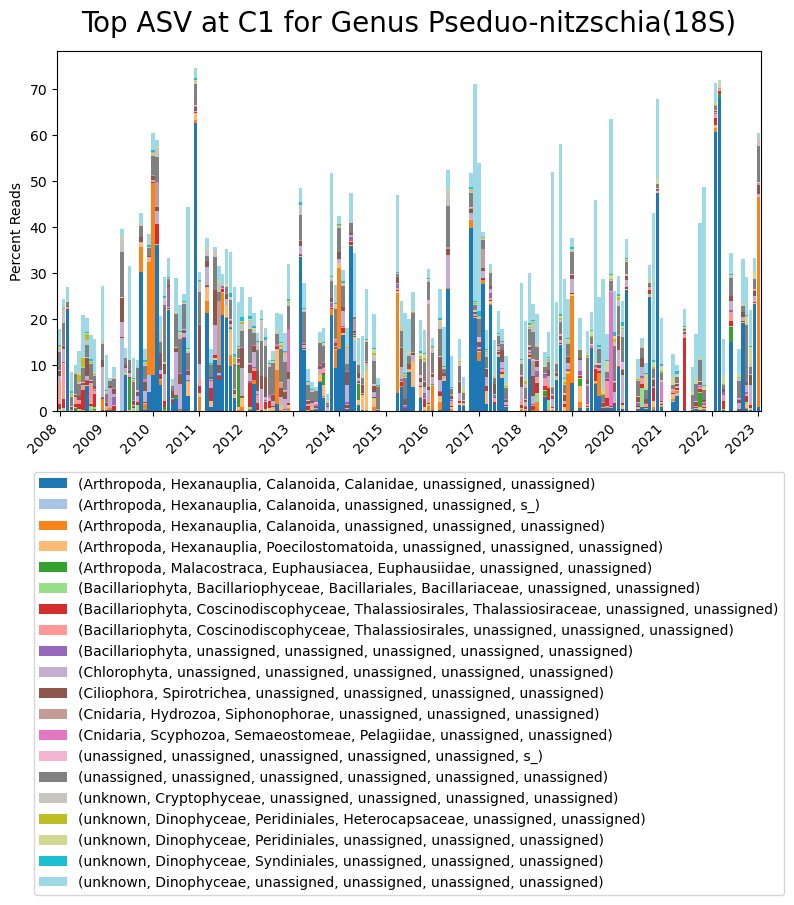

In [68]:
plt.figure(figsize=(6, 4))
ax = df_joined.drop(columns=['sum', 'sum2']).plot(kind='bar', stacked=True, cmap=cmap, width=0.9, alpha=1.0)
plt.title('Top ASV at C1 for Genus Pseduo-nitzschia(18S)', y=1.03, fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor= (0.5, -0.15), ncol=1, fontsize=10)
idx_str = df_joined.index.astype(str)
positions = [i for i, x in enumerate(idx_str) if x.endswith('-01')]
labels = [x[:4] for x in idx_str if x.endswith('-01')]
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(labels, rotation=45, ha='right')
plt.ylabel('Percent Reads')
ax.set_position([0.00, 0.00, 1.1, 0.75])
#plt.savefig("~/Top20_ASV_G_Pseduo.png", dpi=300, bbox_inches='tight') #Save image
plt.show()